In [1]:
# enable autocomplete
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np

import googlemaps

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

# Compare bike ride times to taxi and metro

## Read data and select subset of 200 rides

In [ ]:
df_full = pd.read_csv('data/citibike2018_clean.csv')

In [ ]:
df = df_full.loc[df_full['usertype']=='Subscriber',:].sample(200, random_state=42)

In [ ]:
#df.to_csv('data/citibike2018_subset.csv', index=False)

## Setup API access

In [4]:
with open('Api_key.txt') as f:
    api_key = f.readline()
    f.close

In [5]:
gmaps = googlemaps.Client(key=api_key)

## Compute travel times for bicycling, transit and driving

In [6]:
def get_travel_times(start_lat, start_lon, end_lat, end_lon, departure_time):
    
    ''' Returns travel times in minutes between start and end coordinates for transportation modes "bike", "transit" and "taxi" '''
    
    directions_bicycling = gmaps.directions((start_lat,start_lon), (end_lat,end_lon), mode="bicycling", departure_time=departure_time)
    directions_transit = gmaps.directions((start_lat,start_lon), (end_lat,end_lon), mode="transit", departure_time=departure_time)
    directions_driving = gmaps.directions((start_lat,start_lon), (end_lat,end_lon), mode="driving", departure_time=departure_time)
    
    try:
        duration_bicycling = int(directions_bicycling[0]['legs'][0]['duration']['value']/60)
        duration_transit = int(directions_transit[0]['legs'][0]['duration']['value']/60)
        duration_driving = int(directions_driving[0]['legs'][0]['duration']['value']/60)
    
    except:
        
        if (start_lat == end_lat) & (start_lon == end_lon):
            duration_bicycling = 0
            duration_transit = 0
            duration_driving = 0
        else:
            print(start_lat, start_lon, end_lat, end_lon, departure_time)
    
    return duration_bicycling, duration_transit, duration_driving
    

NOTE: API does not return directions for past times. Therefore, all API requests are made for tomorrow's date

In [7]:
# extract time from starttime
df['departure_time'] = pd.to_datetime(df['starttime']).dt.time

# set departure to tomorrow at departure time
tomorrow = datetime.now().date() + timedelta(days=1)
df['departure'] = [datetime.combine(tomorrow, t) for t in df['departure_time']]

In [8]:
# compute travel times
df[['duration_bicycling','duration_transit','duration_driving']] = df.apply(lambda row: get_travel_times(row['start station latitude'], row['start station longitude'], row['end station latitude'], row['end station longitude'], row['departure']) , axis=1, result_type='expand')

In [9]:
#df.to_csv('data/citibike2018_traveltimes.csv', index=False)

## Analyze and plot results

In [10]:
# compute when bicycling is faster
df['bicycling_faster_than_transit'] = df['duration_bicycling'] <= df['duration_transit']
df['bicycling_faster_than_driving'] = df['duration_bicycling'] <= df['duration_driving']

# compute when bicycling takes equal time
df['bicycling_equal_transit'] = df['duration_bicycling'] == df['duration_transit']
df['bicycling_equal_driving'] = df['duration_bicycling'] == df['duration_driving']

### How often is bicycling faster than transit?

<AxesSubplot:xlabel='bicycling_faster_than_transit'>

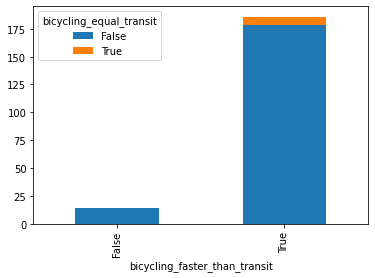

In [11]:
df_plot = df.groupby(['bicycling_faster_than_transit','bicycling_equal_transit']).size().reset_index().pivot(columns='bicycling_equal_transit', index='bicycling_faster_than_transit', values=0)
df_plot.plot(kind='bar', stacked=True)

### How often is bicycling faster than driving?

<AxesSubplot:xlabel='bicycling_faster_than_driving'>

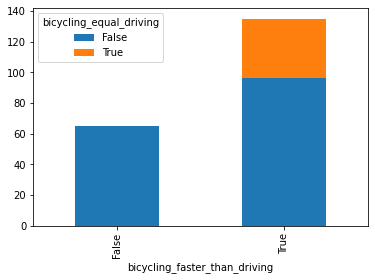

In [12]:
df_plot = df.groupby(['bicycling_faster_than_driving','bicycling_equal_driving']).size().reset_index().pivot(columns='bicycling_equal_driving', index='bicycling_faster_than_driving', values=0)
df_plot.plot(kind='bar', stacked=True)